In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [3]:
# Load dataset
df = pd.read_csv("model.csv")  # Update with your actual path

# Convert target variable to binary
df['Error_found'] = df['Error_found'].map({'no': 0, 'yes': 1})

# Check for nulls
print("Missing Values:\n", df.isnull().sum())

# Treat outliers using percentile capping
def cap_outliers(data, lower=5, upper=95):
    data = data.copy()
    for col in data.select_dtypes(include='number'):
        if col == 'Error_found':
            continue
        low, high = np.percentile(data[col], [lower, upper])
        data[col] = data[col].clip(low, high)
    return data

df = cap_outliers(df)

print("\nCleaned Dataset:")
display(df.head())



Missing Values:
 X-direction    0
Y-direction    0
Z-direction    0
Error_found    0
dtype: int64

Cleaned Dataset:


,X-direction,Y-direction,Z-direction,Error_found
0,0.16,1.02,-7.96,0
1,-0.43,0.98,-7.96,0
2,0.04,0.78,-7.96,0
3,-0.04,0.90,-7.96,0
4,0.00,1.26,-7.77,0


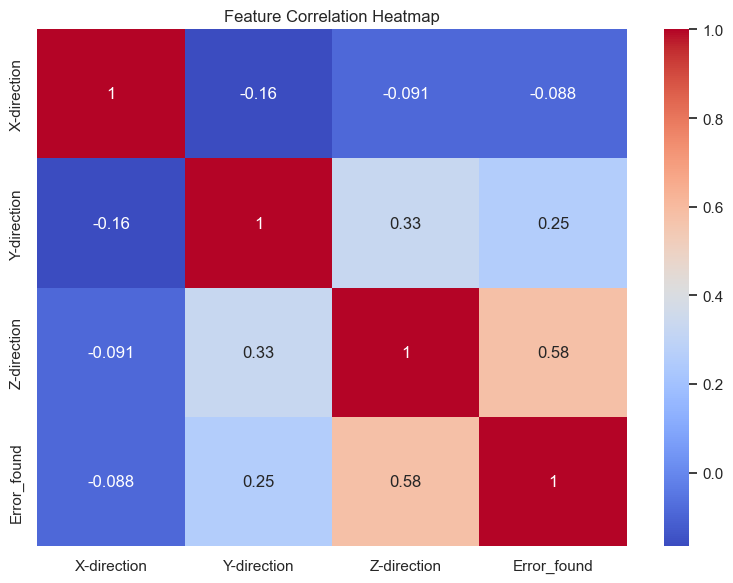

In [4]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [5]:
def define_models():
    base = [
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42))
    ]
    
    models = {
        'LogisticRegression': (
            ImbPipeline(base + [('model', LogisticRegression(max_iter=1000))]),
            {'model__C': [0.01, 0.1, 1, 10]}
        ),
        'RandomForest': (
            ImbPipeline(base + [('model', RandomForestClassifier(random_state=42))]),
            {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 10, 20]
            }
        ),
        'SVC': (
            ImbPipeline(base + [('model', SVC(probability=True, random_state=42))]),
            {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        ),
        'KNN': (
            ImbPipeline(base + [('model', KNeighborsClassifier())]),
            {
                'model__n_neighbors': [3, 5, 7],
                'model__weights': ['uniform', 'distance']
            }
        ),
        'XGBoost': (
            ImbPipeline(base + [('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
            {
                'model__n_estimators': [50, 100],
                'model__learning_rate': [0.01, 0.1],
                'model__max_depth': [3, 5]
            }
        ),
        'NaiveBayes': (
            ImbPipeline(base + [('model', GaussianNB())]),
            {}
        )
    }
    
    return models


In [6]:
# Prepare features and target
X = df[['X-direction', 'Y-direction', 'Z-direction']]
y = df['Error_found']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate all models
results = []
models = define_models()

for name, (pipeline, param_grid) in models.items():
    print(f"\n🚀 Training {name}...")
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': roc,
        'Best Params': grid.best_params_
    })

results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
results_df.reset_index(drop=True, inplace=True)



🚀 Training LogisticRegression...

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        50
           1       0.84      0.93      0.88       167

    accuracy                           0.81       217
   macro avg       0.74      0.67      0.69       217
weighted avg       0.79      0.81      0.80       217

Confusion Matrix:
 [[ 21  29]
 [ 12 155]]

🚀 Training RandomForest...

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.38      0.40        50
           1       0.82      0.85      0.84       167

    accuracy                           0.74       217
   macro avg       0.63      0.62      0.62       217
weighted avg       0.73      0.74      0.74       217

Confusion Matrix:
 [[ 19  31]
 [ 25 142]]

🚀 Training SVC...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.34      0.51        50



✅ Model Comparison Results:


,Model,Accuracy,ROC-AUC,Best Params
0,SVC,0.847926,0.786766,"{'model__C': 0.1, 'model__kernel': 'linear'}"
1,XGBoost,0.847926,0.776168,"{'model__learning_rate': 0.01, 'model__max_dep..."
2,LogisticRegression,0.811060,0.774192,{'model__C': 10}
3,RandomForest,0.741935,0.734910,"{'model__max_depth': 10, 'model__n_estimators'..."
4,NaiveBayes,0.843318,0.681018,{}
5,KNN,0.663594,0.658802,"{'model__n_neighbors': 7, 'model__weights': 'u..."


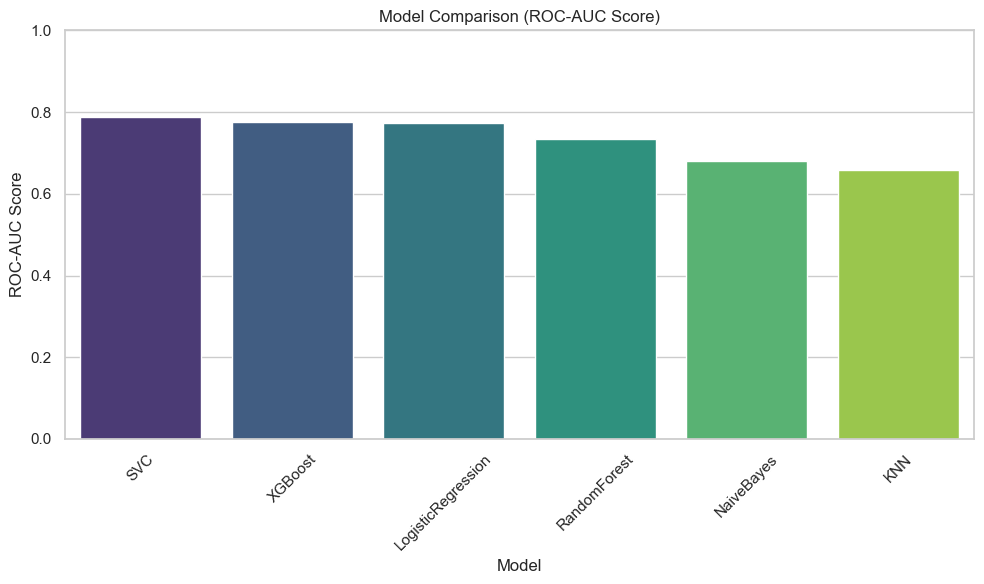

In [7]:
# Display results table
print("\n✅ Model Comparison Results:")
display(results_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='ROC-AUC', palette='viridis')
plt.title("Model Comparison (ROC-AUC Score)")
plt.ylabel("ROC-AUC Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Find the best model index
best_index = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_index, 'Model']
best_params = results_df.loc[best_index, 'Best Params']

print(f"\n✅ Best Model: {best_model_name}")
print(f"📈 Best Accuracy on Validation: {results_df.loc[best_index, 'Accuracy']:.4f}")
print(f"📊 Best ROC-AUC: {results_df.loc[best_index, 'ROC-AUC']:.4f}")
print(f"🔧 Best Params: {best_params}\n")

# Step 2: Get the original pipeline (0th item of tuple)
best_model_pipeline = models[best_model_name][0]

# Step 3: Set best hyperparameters (removing 'model__' prefix)
model_params = {k.replace('model__', ''): v for k, v in best_params.items()}
best_model_pipeline.named_steps['model'].set_params(**model_params)

# Step 4: Train the model on the full training data
best_model_pipeline.fit(X_train, y_train)

# Step 5: Save the trained model to a .pkl file
with open(f'{best_model_name}_best_model.pkl', 'wb') as file:
    pickle.dump(best_model_pipeline, file)
print(f"✅ Model saved as {best_model_name}_best_model.pkl")

# Step 6: Evaluate on test data
y_pred = best_model_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Test Accuracy of {best_model_name}: {test_accuracy:.4f}")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Best Model: SVC
📈 Best Accuracy on Validation: 0.8479
📊 Best ROC-AUC: 0.7868
🔧 Best Params: {'model__C': 0.1, 'model__kernel': 'linear'}

✅ Model saved as SVC_best_model.pkl

🎯 Test Accuracy of SVC: 0.8479
📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.34      0.51        50
           1       0.83      1.00      0.91       167

    accuracy                           0.85       217
   macro avg       0.92      0.67      0.71       217
weighted avg       0.87      0.85      0.82       217

🧮 Confusion Matrix:
 [[ 17  33]
 [  0 167]]
